<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2021/blob/main/sessions/tcga-gbm/RSNA_2021_TCGA_GBM_radiogenomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notes**

- This notebook is optimized to work on **Google Colab**.
- Remember to activate a **GPU runtime**
  - Runtime > Change runtime type > Hardware accelerator: GPU


# Intro & info

Before 2021, glioblastomas (GBMs) used to be classified as IDH1 wild-type (**IDH wt**) or mutant (**IDH mut**).

With the 2021 update of the WHO classification of brain tumors published in 2021, GBMs are now only identified as IDH wt.


Even though not "meaningfull" anymore, this notebook will show you how to develop a machine learning classifier to discriminate IDH mut and IDH wt GBMs using radiomics features extracted from brain MRIs.

We will simulate a full pipeline, from image selection to model creation; specifically we will:
- Retrieve imaging and genomic data
- Match imaging and genomic data
- Obtain the segmentation masks of the lesions
- Extract radiomics features from the segmentation masks
- Develop a classifier

We will use only free and publicly available resources: we will retrieve [imaging](https://portal.imaging.datacommons.cancer.gov/) and [genomic](https://portal.gdc.cancer.gov/) information from the **TCGA-GBM** cohort, use [**HD-GLIO**](https://github.com/NeuroAI-HD/HD-GLIO) to segment the lesions, [**Pyradiomics**](https://pyradiomics.readthedocs.io/en/latest/) to extract the radiomics features, and [**scikit-learn**](https://scikit-learn.org/stable/) to build our classifier.

While this notebook **does not** contain enough data to build a meaningful classifier, it should serve as a starting point to develop a fully functional one.

**Note**: for simplicity, we will refer to IDH1 as "IDH".

# Download the class material

In [ ]:
cd /content/

/content


In [ ]:
# Run this cell at the beginning of the class or in case you will need to start again.

!rm -rf RSNA_2021_radiogenomics
!rm -rf __MACOSX
!rm -rf sample_data
!rm -rf RSNA_2021_radiogenomics.zip
!rm -rf segmentation_output/

In [ ]:
# This cell will download the content for the class.

!gdown --id 1A1N54cRMtDthMIepsQBI17Gxfi5_XOT6
!unzip -q "/content/RSNA_2021_radiogenomics.zip"
!rm -rf __MACOSX

Downloading...
From: https://drive.google.com/uc?id=1A1N54cRMtDthMIepsQBI17Gxfi5_XOT6
To: /content/RSNA_2021_radiogenomics.zip
100% 260M/260M [00:01<00:00, 155MB/s]


# Install necessary resources:

- HD-GLIO (https://github.com/NeuroAI-HD/HD-GLIO)

- Pyradiomics (https://pyradiomics.readthedocs.io/en/latest/index.html)

- Python libraries

## Install HD-GLIO

In [ ]:
!pip install hd_glio

     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 251 kB 10.1 MB/s 
     |████████████████████████████████| 48.4 MB 5.1 kB/s 
     |████████████████████████████████| 151 kB 41.3 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 43.9 MB/s 
  Created wheel for nnunet: filename=nnunet-1.7.0-py3-none-any.whl size=487821 sha256=1a8ceeb2890557ae926172c4eb22c8480584678ac8aa038514ff25698b2439c8
  Stored in directory: /root/.cache/pip/wheels/66/f6/19/c51389976a9ae30212178d1c41497893504b900f043fe1c665
  Created wheel for batchgenerators: filename=batchgenerators-0.23-py3-none-any.whl size=84780 sha256=2911b8ef0f9771b5b7ddf53821c2f3342bb7033012959da49137fccb68a8e290
  Stored in directory: /root/.cache/pip/wheels/81/3d/a2/9a602ce56458c684d2962ec89eddd6bc06b00687735e2dd11a
  Created wheel for dicom2nifti: filename=dicom2nifti-2.3.0-py3-none-any.whl size=42932 sha256=d32154252288f41dc5c2122dddfb4

## Install pyradiomics

In [ ]:
!python -m pip install pyradiomics
!pyradiomics -h

     |████████████████████████████████| 188 kB 5.4 MB/s 
     |████████████████████████████████| 109 kB 41.9 MB/s 
     |████████████████████████████████| 546 kB 38.9 MB/s 
usage: pyradiomics image|batch [mask] [Options]

optional arguments:
  -h, --help            show this help message and exit
  --label N, -l N       (DEPRECATED) Value of label in mask to use for
                        feature extraction.
  --version             Print version and exit

Input:
  Input files and arguments defining the extraction:
  - image and mask files (single mode) or CSV-file specifying them (batch mode)
  - Parameter file (.yml/.yaml or .json)
  - Overrides for customization type 3 ("settings")
  - Multi-threaded batch processing

  {Image,Batch}FILE     Image file (single mode) or CSV batch file (batch mode)
  MaskFILE              Mask file identifying the ROI in the Image. 
                        Only required when in single mode, ignored otherwise.
  --param FILE, -p FILE
                  

NOTE:
After installing the packages, it is possible that you will need to restart the notebook.

If so, please make sure to select the correct runtime (GPU).

## Import libraries

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import gdown
import statistics
from scipy import stats
from collections import Counter
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.decomposition import PCA


from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC


from joblib import dump, load


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate


pd.set_option('display.max_colwidth', None)
%matplotlib inline

# Work with NIH cloud resources: Imaging Data Commons and Genomic Data Commons

The data that we will use in this notebook are part of the TCGA and TCIA initiatives:

- The genomic data will be obtained from the [Genomic Data Commons](https://portal.gdc.cancer.gov/) (GDC) portal.


- The imaging data will be obtained from the [Imaging Data Commons](https://portal.imaging.datacommons.cancer.gov/) (IDC) portal. 

A separate session of this Deep Learning Lab will show you how to work with IDC tools (you can find a list of the classes [here](https://github.com/RSNA/AI-Deep-Learning-Lab-2021#lessons)); once you'll be familiar with the IDC portal, you can run the next cells to retrieve the imaging data used in this class directly from the IDC portal.

## Query the TCGA-GBM cohort from the IDC platform using BigQuery
This cohort contains both pre- and post-surgery studies.
Since we are interested in the pre-surgery studies, the query will include only the earliest study for each subject.

We will save this information in a pandas dataframe called "tcga_gbm_mri".

**Note:** You'll be able to run the following cells only with a valid ProjectID to use to query the IDC portal. If you do not have one, the class material includes a csv file with the output of the query performed with BigQuery. 

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# Specify the project ID that points to your GCP project for billing purposes

# myProjectID="insert your project ID"
# myProjectID = "idc-external-005"

In [ ]:
# %%bigquery tcga_gbm_mri --project=$myProjectID


# SELECT
#     P.PatientID,
#     P.StudyDate,
#     P.StudyInstanceUID,
#     P.gcs_url
# FROM
#     `canceridc-data.idc_views.dicom_all` AS P
# WHERE
#     P.collection_id = "tcga_gbm"
#     AND
#     P.Modality = "MR"
#     AND
#     P.StudyDate = 
#     (
#         SELECT
#             MIN(C.StudyDate)
#         FROM
#             `canceridc-data.idc_views.dicom_all` AS C
#         WHERE
#             P.PatientID = C.PatientID
#             AND
#             C.collection_id = "tcga_gbm"
#             AND
#             C.Modality = "MR"
#     )
# ORDER BY
# P.PatientID

The next cell will load the same dataframe that you would obtain running the BigQuery command.

In [ ]:
tcga_gbm_mri = pd.read_csv('/content/RSNA_2021_radiogenomics/dataframes/tcga-gbm-mri.csv')

Let's visualize the dataframe

In [ ]:
tcga_gbm_mri

,PatientID,StudyDate,StudyInstanceUID,gcs_url
0,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239/1.3.6.1.4.1.14519.5.2.1.1706.4001.166909646801864710106680106577/1.3.6.1.4.1.14519.5.2.1.1706.4001.167086490842437876938647969587.dcm#1592632444497936
1,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239/1.3.6.1.4.1.14519.5.2.1.1706.4001.220079143670418535732331991740/1.3.6.1.4.1.14519.5.2.1.1706.4001.236214811841064268884423232173.dcm#1592632445392121
2,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239/1.3.6.1.4.1.14519.5.2.1.1706.4001.769579767788431533139923490444/1.3.6.1.4.1.14519.5.2.1.1706.4001.208348539845341382214255518091.dcm#1592632452646220
3,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239/1.3.6.1.4.1.14519.5.2.1.1706.4001.220079143670418535732331991740/1.3.6.1.4.1.14519.5.2.1.1706.4001.318132908168153014116151018728.dcm#1592632445615303
4,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239/1.3.6.1.4.1.14519.5.2.1.1706.4001.251438991621054435135635316288/1.3.6.1.4.1.14519.5.2.1.1706.4001.156969405813369045494211424131.dcm#1592632446808306
...,...,...,...,...
249097,TCGA-76-6664,2002-01-10,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790/1.3.6.1.4.1.14519.5.2.1.1188.4001.389257941149430865272632802151/1.3.6.1.4.1.14519.5.2.1.1188.4001.202546674010486696285261492463.dcm#1592632390633946
249098,TCGA-76-6664,2002-01-10,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790/1.3.6.1.4.1.14519.5.2.1.1188.4001.188264273641316994799482740951/1.3.6.1.4.1.14519.5.2.1.1188.4001.229313002893141972087344570790.dcm#1592632380657362
249099,TCGA-76-6664,2002-01-10,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790/1.3.6.1.4.1.14519.5.2.1.1188.4001.855165780560370170340861980177/1.3.6.1.4.1.14519.5.2.1.1188.4001.168831593071407215526929664469.dcm#1592632392107036
249100,TCGA-76-6664,2002-01-10,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811965887839758381790/1.3.6.1.4.1.14519.5.2.1.1188.4001.335865847502058292190362745019/1.3.6.1.4.1.14519.5.2.1.1188.4001.141128286030533757075223185103.dcm#1592632386260670


Now let's check how many patients and how many exams we have

In [ ]:
num_subjects = len(tcga_gbm_mri["PatientID"].unique())
num_studies = len(tcga_gbm_mri["StudyInstanceUID"].unique())
print(f"Total number of subjects: {num_subjects}")
print(f"Total number of studies: {num_studies}")

Total number of subjects: 259
Total number of studies: 284


We have more studies than subjects, meaning that some subjects have multiple studies performed the same day.

There is no programmatic way of knowing which study to include; the only option is to manually review these cases and select the ones to include.

**Note: Know your data**

Datasets are rarely ready to use to develop ML models; it is fundamental to perform quality control of the data you are going to use, or you will end up with a useless model.

For example, the cohort we are using contains more than one study per subject, and within each study, there could be repeated scans (usually because of motion artefacts; for example see the MRIs subject TCGA-08-0522). Moreover, some of the cases do not have a pre-surgery scan, so they will need to be excluded from the analysis.

## Match imaging and genomic information

We obtained the IDH1 mutational status information from the Genomic Data Commons portal (GDC) (https://portal.gdc.cancer.gov/).

You can find the spreadsheet with the genomic information "IDH_mutant_TCGA-GBM.csv" in /content/RSNA_2021_radiogenomics/dataframes

In [ ]:
# Load the files with the imaging and genomic information and store them as a pandas dataframe
tcga_gbm_mri = pd.read_csv('/content/RSNA_2021_radiogenomics/dataframes/tcga-gbm-mri.csv') #imaging dataframe
idh_df = pd.read_csv('/content/RSNA_2021_radiogenomics/dataframes/IDH_mutant_TCGA-GBM.csv') #genomic dataframe
idh_df # visualize the dataframe

,Case ID,Project,Gender,Age at diagnosis,Days to death,Vital Status,Primary Diagnosis
0,TCGA-12-0818,TCGA-GBM,Female,45 years 230 days,7 years 235 days,Dead,Glioblastoma
1,TCGA-12-1088,TCGA-GBM,Female,53 years 309 days,10 years 229 days,Dead,Glioblastoma
2,TCGA-16-1460,TCGA-GBM,Female,36 years 59 days,--,Alive,Glioblastoma
3,TCGA-26-1442,TCGA-GBM,Male,43 years 245 days,--,Alive,Glioblastoma
4,TCGA-06-5417,TCGA-GBM,Female,45 years 136 days,--,Alive,Glioblastoma
5,TCGA-14-1456,TCGA-GBM,Male,23 years 310 days,--,Alive,Glioblastoma
6,TCGA-06-6701,TCGA-GBM,Male,60 years 136 days,--,Alive,Glioblastoma
7,TCGA-27-2521,TCGA-GBM,Male,34 years 267 days,1 year 145 days,Dead,Glioblastoma
8,TCGA-06-1805,TCGA-GBM,Female,28 years 315 days,--,Alive,Glioblastoma
9,TCGA-06-2570,TCGA-GBM,Female,21 years 266 days,--,Alive,Glioblastoma


In [ ]:
# First let's make a copy of the original dataframe
tcga_gbm_mri_idh = tcga_gbm_mri.copy()

#### Some of the subjects for which we have genomic data available might not have an available MRI.

Let's check how many subjects of the genomic dataframe are missing from the imaging dataframe.

In [ ]:
# Finds the differences between the IDs columns of the two dataframes
missing_subjects = set(idh_df['Case ID']).difference(set(tcga_gbm_mri_idh['PatientID']))

print(f"A total of {len(missing_subjects)} subjects are missing from the imaging dataframe.")
print("The missing subjects are: "+ str(missing_subjects))


A total of 13 subjects are missing from the imaging dataframe.
The missing subjects are: {'TCGA-16-1460', 'TCGA-12-0818', 'TCGA-16-0849', 'TCGA-26-1442', 'TCGA-14-4157', 'TCGA-06-1805', 'TCGA-12-1088', 'TCGA-02-2483', 'TCGA-32-4208', 'TCGA-06-A7TL', 'TCGA-16-0850', 'TCGA-12-0827', 'TCGA-19-A6J5'}


#### Now let's add the IDH status information for the subjects that are present in both dataframes.


In [ ]:
# Add '1' to all images corresponding to an IDH mutant subject and '0' to IDH wt
tcga_gbm_mri_idh['IDH Status'] = tcga_gbm_mri_idh['PatientID'].isin(idh_df['Case ID']).astype(int)

In [ ]:
# List all the images for the IDH mutant subjects
tcga_gbm_mri_idh.loc[tcga_gbm_mri_idh['IDH Status'] == 1]

,PatientID,StudyDate,StudyInstanceUID,gcs_url,IDH Status
38896,TCGA-06-0128,1999-02-18,1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438/1.3.6.1.4.1.14519.5.2.1.4591.4001.393766610979582366190694521912/1.3.6.1.4.1.14519.5.2.1.4591.4001.171557872351567551025925819456.dcm#1592634418659082,1
38897,TCGA-06-0128,1999-02-18,1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438/1.3.6.1.4.1.14519.5.2.1.4591.4001.393766610979582366190694521912/1.3.6.1.4.1.14519.5.2.1.4591.4001.284775327422206825152911081649.dcm#1592634420394691,1
38898,TCGA-06-0128,1999-02-18,1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438/1.3.6.1.4.1.14519.5.2.1.4591.4001.697735598413555636533908203783/1.3.6.1.4.1.14519.5.2.1.4591.4001.574793276512372302574154076700.dcm#1592634427097418,1
38899,TCGA-06-0128,1999-02-18,1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438/1.3.6.1.4.1.14519.5.2.1.4591.4001.120673894695124200101185494671/1.3.6.1.4.1.14519.5.2.1.4591.4001.271340630255077704288325762495.dcm#1592634416703134,1
38900,TCGA-06-0128,1999-02-18,1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.4591.4001.197146947506099366832803736438/1.3.6.1.4.1.14519.5.2.1.4591.4001.393766610979582366190694521912/1.3.6.1.4.1.14519.5.2.1.4591.4001.184346112106419794875908281833.dcm#1592634419002701,1
...,...,...,...,...,...
232097,TCGA-27-2521,1987-07-09,1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458/1.3.6.1.4.1.14519.5.2.1.3775.4001.123762435054161578259889405532/1.3.6.1.4.1.14519.5.2.1.3775.4001.264354085290190965758735687612.dcm#1592633474579717,1
232098,TCGA-27-2521,1987-07-09,1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458/1.3.6.1.4.1.14519.5.2.1.3775.4001.123762435054161578259889405532/1.3.6.1.4.1.14519.5.2.1.3775.4001.324217170656526126118133886378.dcm#1592633475100691,1
232099,TCGA-27-2521,1987-07-09,1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458/1.3.6.1.4.1.14519.5.2.1.3775.4001.123762435054161578259889405532/1.3.6.1.4.1.14519.5.2.1.3775.4001.300669859167390476086433821893.dcm#1592633474819596,1
232100,TCGA-27-2521,1987-07-09,1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519.5.2.1.3775.4001.119470023222804500108388734458/1.3.6.1.4.1.14519.5.2.1.3775.4001.123762435054161578259889405532/1.3.6.1.4.1.14519.5.2.1.3775.4001.198025877641118642868851179940.dcm#1592633474142291,1


In [ ]:
# Let's visualize only the PatientID and the StudyDate of the IDH mutant class
tcga_gbm_mri_idh.loc[tcga_gbm_mri_idh['IDH Status'] == 1].drop(['gcs_url','StudyInstanceUID'],axis=1).drop_duplicates(['PatientID','StudyDate'])

,PatientID,StudyDate,IDH Status
38896,TCGA-06-0128,1999-02-18,1
40673,TCGA-06-0129,2000-03-14,1
95028,TCGA-06-0221,1998-06-30,1
134124,TCGA-06-2570,2007-07-26,1
146347,TCGA-06-5417,2008-09-03,1
149936,TCGA-06-6389,2009-04-04,1
153634,TCGA-06-6701,2009-06-06,1
189944,TCGA-14-0871,1991-07-05,1
191987,TCGA-14-1456,1999-04-22,1
192291,TCGA-14-1458,2000-06-25,1


# HD-GLIO: obtain segmentation masks
At this point, we have both imaging and genomic information. Our next step will be obtaining the segmentation of the lesions using HD-GLIO.

HD-GLIO is the result of a joint project between the Department of Neuroradiology at the Heidelberg University Hospital, Germany and the Division of Medical Image Computing at the German Cancer Research Center (DKFZ) Heidelberg, Germany. It requires four MRI sequences (pre-contrast and post-contrast T1, T2 and FLAIR) to obtain the segmentation of the lesions.

For this notebook, we will use a version of HD-GLIO that can work only with nifti files and requires data to be already processed and registered. Another version, [HD-GLIO-AUTO](https://github.com/NeuroAI-HD/HD-GLIO-AUTO), can work directly with raw files, either dicom or nifti, and do not needs sequences to be preprocessed.

For more information see https://github.com/NeuroAI-HD/HD-GLIO

There are two scripts available to run HD-GLIO:
- One better suited to perform predictions on multiple subjects.
- One to make a prediction on a single subject.

For more information see [here](https://github.com/NeuroAI-HD/HD-GLIO#run-hd-glio).

**Note before starting the segmentation:**

If the process will take more than few minutes, make sure you are using a GPU by checking the current runtime.

### Run HD-GLIO pointing to an input folder (best for multiple predictions):

Let's navigate to the folder containing the example.

In [ ]:
cd /content/RSNA_2021_radiogenomics/imaging/hd-glio_test/TCGA-06-2570

/content/RSNA_2021_radiogenomics/imaging/hd-glio_test/TCGA-06-2570


INPUT_FOLDER hereby contains the T1, T1C, T2 and FLAIR images. In order to ensure that HD-GLIO correctly assigns filenames to modalities, you must apply the following naming convention to your data

- INPUT_T1: PATIENT_IDENTIFIER_0000.nii.gz
- INPUT_CT1: PATIENT_IDENTIFIER_0001.nii.gz
- INPUT_T2: PATIENT_IDENTIFIER_0002.nii.gz
- INPUT_FLAIR: PATIENT_IDENTIFIER_0003.nii.gz

Run HD-GLIO to obtain the segmentation.

In [ ]:
!hd_glio_predict_folder -i input_folder -o segmentation_output


########################
If you are using hd-bet, please cite the following papers:

Kickingereder P, Isensee F, Tursunova I, Petersen J, Neuberger U, Bonekamp D, Brugnara G, Schell M, Kessler T, Foltyn M, Harting I, Sahm F, Prager M, Nowosielski M, Wick A, Nolden M, Radbruch A, Debus J, Schlemmer HP, Heiland S, Platten M, von Deimling A, van den Bent MJ, Gorlia T, Wick W, Bendszus M, Maier-Hein KH. Automated quantitative tumour response assessment of MRI in neuro-oncology with artificial neural networks: a multicentre, retrospective study. Lancet Oncol. 2019 May;20(5):728-740. https://doi.org/10.1016/S1470-2045(19)30098-1

Isensee, Fabian, et al. "nnU-Net: Breaking the Spell on Successful Medical Image Segmentation." arXiv preprint arXiv:1904.08128 (2019). (https://arxiv.org/abs/1904.08128)

This model expects 4 input modalities for each image
Found 1 unique case ids, here are some examples: ['TCGA-06-2570']
If they don't look right, make sure to double check your filenames. They mus

### Run HD-GLIO pointing to single files (best for single predictions):

In [ ]:
cd /content/RSNA_2021_radiogenomics/imaging/hd-glio_test/TCGA-06-2570/single_files

/content/RSNA_2021_radiogenomics/imaging/hd-glio_test/TCGA-06-2570/single_files


In [ ]:
!hd_glio_predict -t1 t1.nii.gz -t1c ct1.nii.gz -t2 t2.nii.gz -flair flair.nii.gz -o segmentation.nii.gz


########################
If you are using hd-bet, please cite the following papers:

Kickingereder P, Isensee F, Tursunova I, Petersen J, Neuberger U, Bonekamp D, Brugnara G, Schell M, Kessler T, Foltyn M, Harting I, Sahm F, Prager M, Nowosielski M, Wick A, Nolden M, Radbruch A, Debus J, Schlemmer HP, Heiland S, Platten M, von Deimling A, van den Bent MJ, Gorlia T, Wick W, Bendszus M, Maier-Hein KH. Automated quantitative tumour response assessment of MRI in neuro-oncology with artificial neural networks: a multicentre, retrospective study. Lancet Oncol. 2019 May;20(5):728-740. https://doi.org/10.1016/S1470-2045(19)30098-1

Isensee, Fabian, et al. "nnU-Net: Breaking the Spell on Successful Medical Image Segmentation." arXiv preprint arXiv:1904.08128 (2019). (https://arxiv.org/abs/1904.08128)

emptying cuda cache
loading parameters for folds, (0,)
using the following model files:  ['/root/hd_glio_params/fold_0/model_final_checkpoint.model']
starting preprocessing generator
starting pre

# Pyradiomics: radiomics features extraction
Now that we have obtained the segmentation masks, we will extract radiomics features from them using Pyradiomics.

At this stage, we will use [Pyradiomics](https://pyradiomics.readthedocs.io/en/latest/) to extract radiomics features from the segmentation masks.

In this case, the segmentation masks are marked with different labels corresponding to different regions of the tumors:
- Label 1: T2/FLAIR hyperintensities.
- Label 2: enhancing area.


**Note:** different segmentation algorithm might genereate different segmentation masks in which tumors' regions could be marked with different labels.

Pyradiomics can extract radiomics features from each of these regions independently, specyfing the "Label" parameter during the extraction. This can be done both at the parameters file level (YML) or in the CSV file used as input for the extraction.

Alternatively, we could choose to extract radiomics features from a single mask containing the whole lesion. To achieve this, we would first need to binarize the segmentation masks so that all areas containing the lesion will be labeled with 1 and everything else with 0 (you can try this at home!).

In [ ]:
cd /content/RSNA_2021_radiogenomics

/content/RSNA_2021_radiogenomics


In [ ]:
# Loads the csv file containing the genomic data

idh_df = pd.read_csv('/content/RSNA_2021_radiogenomics/dataframes/IDH_mutant_TCGA-GBM.csv')

In [ ]:
# Prints the list of the subjects with an IDH for the mutant cases

idh_mutant_list = idh_df['Case ID'].tolist()
for i in idh_mutant_list:
    print(i)

TCGA-12-0818
TCGA-12-1088
TCGA-16-1460
TCGA-26-1442
TCGA-06-5417
TCGA-14-1456
TCGA-06-6701
TCGA-27-2521
TCGA-06-1805
TCGA-06-2570
TCGA-06-6389
TCGA-16-0849
TCGA-06-0221
TCGA-19-1788
TCGA-16-0850
TCGA-19-A6J5
TCGA-14-4157
TCGA-14-1458
TCGA-06-A7TL
TCGA-06-0129
TCGA-19-2629
TCGA-02-2483
TCGA-14-1821
TCGA-12-0827
TCGA-32-4208
TCGA-06-0128
TCGA-14-0871
TCGA-19-1389


To simplify further steps, we will add a label to the folders containing the MRIs: 

- 0: for IDH WT subjects
- 1: for IDH mut subjects

In [ ]:
# Change the folder name of the subjects, adding '1' to those who have the IDH mutation and '0' to those who don't have it.

subjects_dir = Path('/content/RSNA_2021_radiogenomics/imaging/processed_nifti')

for subject in subjects_dir.iterdir():
    if subject.is_dir():
        if str(subject.parts[-1]) in idh_mutant_list: # checks if the PatientID is among the mutant cases
            print(subject)
            source = str(subject)
            dest = source+'_1'
            print(dest)
            os.rename(source,dest)
        else:
            source = str(subject)
            dest = source+'_0'
            print(dest)
            os.rename(source,dest)

/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-14-1821
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-14-1821_1
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-06-5417
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-06-5417_1
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-06-6389
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-06-6389_1
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-06-0122_0
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-08-0390_0
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-06-0128
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-06-0128_1
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-08-0360_0
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-08-0392_0
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-14-0871
/content/RSNA_2021_radiogenomics/imaging/processed_nifti/TCGA-14-0871_1
/c

There are [different options](https://pyradiomics.readthedocs.io/en/latest/usage.html#usage) to choose from to run the radiomics features extraction in Pyradiomics.

In this case, we will opt for the command line usage and the [batch mode](https://pyradiomics.readthedocs.io/en/latest/usage.html#batch-mode), so all we need is a CSV file containing at least three columns:

- Patient ID (PID)
- File paths to the images (MRIs to extract the features from)
- File paths to the masks (segmentations to use for the extraction)

We will then add another columns in which we'll store the IDH status.

We can choose to extract the radiomics features from any of the 4 MRI sequences; in this example, the features will be extracted from the T2-w MRIs; you can try to modify the following cell to include instead the FLAIR or post-contrast T1-w MRIs.

In [ ]:
# Obtain the csv file that we'll use as input for Pyradiomics.

T2_list = []
mask_list = []

p = Path('/content/RSNA_2021_radiogenomics/imaging/processed_nifti')

T2_list = list(p.rglob('t2.nii.gz'))
mask_list = list(p.rglob('segmentation.nii.gz'))

PID = []
IDH_label = []
T2_path = []
mask_path = []

for t2,mask in zip(sorted(T2_list),sorted(mask_list)):
    PID.append(t2.parts[-2])
    IDH_label.append(t2.parts[-2][-1])
    T2_path.append(str(t2))
    mask_path.append(str(mask))

dict_T2 = {'PID':PID,'Image': T2_path, 'Mask': mask_path, 'IDH Status': IDH_label}
df_T2 = pd.DataFrame(dict_T2)
df_T2.set_index('PID', inplace=True)
df_T2.to_csv(r"/content/RSNA_2021_radiogenomics/pyradiomics_files/inputs/T2_input.csv")


### Run the extraction

To run the extraction, all we'll need to specify is:
- the location of the CSV input file;
- the location where to store the output CSV file;
- the location of the YML parameters file containing the settings for the extraction


While the extraction runs, we'll have a look at the **YML file** containing the extraction parameters: /content/RSNA_2021_radiogenomics/pyradiomics_files/YML_files/pyradiomics_parameters.yml

You can find more examples of YML files [here](https://github.com/AIM-Harvard/pyradiomics/tree/master/examples/exampleSettings).

In [ ]:
# The following line will run the command to extract radiomics features from T2-w MRIs.

!pyradiomics /content/RSNA_2021_radiogenomics/pyradiomics_files/inputs/T2_input.csv -o /content/RSNA_2021_radiogenomics/pyradiomics_files/outputs/T2_radiomics_output.csv -f csv -p /content/RSNA_2021_radiogenomics/pyradiomics_files/YML_files/pyradiomics_parameters.yml -v 5



[2021-11-22 01:17:22] D: radiomics.script: Logging initialized
[2021-11-22 01:17:22] I: radiomics.script: Starting PyRadiomics (version: v3.0.1)
[2021-11-22 01:17:22] I: radiomics.script: Processing input...
[2021-11-22 01:17:22] D: radiomics.script: Loading batch file "/content/RSNA_2021_radiogenomics/pyradiomics_files/inputs/T2_input.csv"
[2021-11-22 01:17:22] D: radiomics.script: No overrides found
[2021-11-22 01:17:22] I: radiomics.featureextractor: Loading parameter file /content/RSNA_2021_radiogenomics/pyradiomics_files/YML_files/pyradiomics_parameters.yml
[2021-11-22 01:17:22] D: radiomics.featureextractor: Parameters parsed, input is valid.
[2021-11-22 01:17:22] D: radiomics.featureextractor: Applying settings
[2021-11-22 01:17:22] D: radiomics.featureextractor: Enabled image types: {'Original': {}}
[2021-11-22 01:17:22] D: radiomics.featureextractor: Enabled features: {'shape': None, 'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterS

### Congratulations! You have now extracted radiomics features from T2-w MRIs.

You can find the CSV file called "T2_output.csv" here: /content/RSNA_2021_radiogenomics/pyradiomics_files/outputs/T2_radiomics_output.csv

# Scikit-learn: develop a ML model
Now we can finally use the radiomics features extracted fromt the segmentation masks to build our classifier using [Scikit-learn](https://scikit-learn.org/stable/).

## Load the data
The starting point for our analysis will be the CSV file containing the radiomics features extracted using Pyradiomics.

In [ ]:
# Loads the dataset.
df_train = pd.read_csv('/content/RSNA_2021_radiogenomics/pyradiomics_files/outputs/T2_radiomics_output.csv', index_col='PID')

# Prints some basic information about the file.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, TCGA-06-0122_0 to TCGA-14-1821_1
Columns: 140 entries, Image to original_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(109), int64(5), object(26)
memory usage: 15.4+ KB


## Check for missing values and drop NaN

In [ ]:
# Obtain the number of missing values per column in the training set
display(df_train.isnull().sum())

Image                                                 0
Mask                                                  0
IDH Status                                            0
diagnostics_Versions_PyRadiomics                      0
diagnostics_Versions_Numpy                            0
                                                     ..
original_gldm_LargeDependenceLowGrayLevelEmphasis     0
original_gldm_LowGrayLevelEmphasis                    0
original_gldm_SmallDependenceEmphasis                 0
original_gldm_SmallDependenceHighGrayLevelEmphasis    0
original_gldm_SmallDependenceLowGrayLevelEmphasis     0
Length: 140, dtype: int64

In [ ]:
df_train = df_train.dropna()

In [ ]:
display(df_train.isnull().sum())

Image                                                 0
Mask                                                  0
IDH Status                                            0
diagnostics_Versions_PyRadiomics                      0
diagnostics_Versions_Numpy                            0
                                                     ..
original_gldm_LargeDependenceLowGrayLevelEmphasis     0
original_gldm_LowGrayLevelEmphasis                    0
original_gldm_SmallDependenceEmphasis                 0
original_gldm_SmallDependenceHighGrayLevelEmphasis    0
original_gldm_SmallDependenceLowGrayLevelEmphasis     0
Length: 140, dtype: int64

In [ ]:
df_train.describe()

,IDH Status,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,diagnostics_Mask-interpolated_Mean,diagnostics_Mask-interpolated_Minimum,diagnostics_Mask-interpolated_Maximum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,1.400000e+01,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,1.400000e+01,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.500000,93.786816,-18.616105,1947.524048,24435.642857,33.000000,195.267921,-69.930807,666.463037,34880.071429,33.000000,345.177804,80.571138,574.555585,0.747828,0.566649,31.259496,56.041860,54.412275,64.143388,63.528904,68.810432,34528.541667,41.458578,0.318014,13743.970488,0.868908,34880.071429,239.385669,439.468347,1.477886e+10,3.

## Encode 'IDH Status' using the LabelEncoder function

**Note**: in this example, the classes are already labeled as 0 for IDH wt and 1 for IDH mutant cases, so the following code is redundant.

Nevertheless, in case the classes would be labeled for example as "wt" for the IDH wt and "mut" for the IDH mutant cases, the following code would take care of generate proper labels for the training process.

More info [here](https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets).

In [ ]:
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

# Fit the encoder to the pandas column
le.fit(df_train['IDH Status'])

# View the labels
list(le.classes_)

[0, 1]

In [ ]:
# Apply the fitted encoder to the pandas column
le.transform(df_train['IDH Status'])

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
# Substitutes the original labels with the encoded ones
df_train['IDH Status'] = le.transform(df_train['IDH Status'])

## Separate features and IDH status columns

In [ ]:
# Separates features from labels: IDH mutation = 0 (wild type) or 1 (mutant)

X_training = df_train.drop(['IDH Status'], axis=1) # features
y_training = df_train['IDH Status'] # labels

# Drops Image and Mask columns since they contain info that we don't need anymore

X_training = X_training.drop(['Image','Mask'], axis=1)

## Separate radiomics features based on feature types (shape, first order, texture)

Note: the "diagnostics" columns contains information on how the features were extracted, so they won't be used during training.

In [ ]:
features_list = X_training.columns.to_list()

In [ ]:
type(features_list), len(features_list)

(list, 137)

In [ ]:
diagnostics_parameters = []
shape_features = []
first_order_features = []
texture_features = []

for feature in X_training.columns:
    if 'diagnostics' in feature:
        diagnostics_parameters.append(feature)
    elif 'shape' in feature:
        shape_features.append(feature)
    elif 'firstorder' in feature:
        first_order_features.append(feature)
    else:
        texture_features.append(feature)

Let's print each group of features:

In [ ]:
shape_features

['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume']

In [ ]:
first_order_features

['original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance']

In [ ]:
texture_features

['original_glcm_Autocorrelation',
 'original_glcm_JointAverage',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterShade',
 'original_glcm_ClusterTendency',
 'original_glcm_Contrast',
 'original_glcm_Correlation',
 'original_glcm_DifferenceAverage',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceVariance',
 'original_glcm_JointEnergy',
 'original_glcm_JointEntropy',
 'original_glcm_Imc1',
 'original_glcm_Imc2',
 'original_glcm_Idm',
 'original_glcm_Idmn',
 'original_glcm_Id',
 'original_glcm_Idn',
 'original_glcm_InverseVariance',
 'original_glcm_MaximumProbability',
 'original_glcm_SumEntropy',
 'original_glcm_SumSquares',
 'original_glrlm_GrayLevelNonUniformity',
 'original_glrlm_GrayLevelNonUniformityNormalized',
 'original_glrlm_GrayLevelVariance',
 'original_glrlm_HighGrayLevelRunEmphasis',
 'original_glrlm_LongRunEmphasis',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'original_glrlm_LongRunLowGrayLevelEmphasis',
 'original_glrlm_LowGrayLevelRunEmphasi

In [ ]:
# Total number of features

len(shape_features+texture_features+first_order_features)

100

In [ ]:
# Creates separates dataframe for each sets of features

diagnostics_df = X_training[diagnostics_parameters]
shape_df = X_training[shape_features]
firstorder_df = X_training[first_order_features]
texture_df = X_training[texture_features]

In [ ]:
# Shows the shape features; try to modify this cell to show the other dataframes

shape_df

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
PID,,,,,,,,,,,,,,
TCGA-06-0122_0,0.934136,0.609635,18.072318,29.644496,38.897301,40.792156,31.780497,42.497059,558.208333,27.691977,0.246198,1331.672975,2.385620,736.0
TCGA-06-0128_1,0.928172,0.802088,53.382043,66.553852,73.756356,77.878110,76.118329,79.082236,57282.375000,61.773416,0.330193,21763.593501,0.379935,57390.0
TCGA-06-0129_1,0.787309,0.641409,41.891449,65.311619,63.505905,75.690158,78.924014,84.776176,80672.791667,51.420452,0.498121,18125.936187,0.224685,80745.0
TCGA-06-0137_0,0.899935,0.731292,29.004754,39.662359,52.345009,54.037024,53.150729,54.872580,6589.750000,35.693539,0.261423,6502.094038,0.986698,7195.0
TCGA-06-0138_0,0.729993,0.578081,26.039718,45.045080,52.201533,59.908263,59.464275,65.467549,15113.583333,32.882586,0.287082,10297.288378,0.681327,15565.0
TCGA-06-2570_1,0.656934,0.557493,26.715424,47.920607,41.146081,55.000000,52.009614,57.323643,24590.458333,31.480691,0.526776,7763.109631,0.315696,24733.0
TCGA-06-5417_1,0.675675,0.489613,38.889260,79.428635,70.830784,82.764727,74.431176,84.362314,71846.875000,53.667905,0.255155,32755.530281,0.455908,72190.0
TCGA-06-6389_1,0.688400,0.528041,24.408146,46.223938,37.013511,44.384682,48.083261,48.548944,3286.208333,31.820549,0.159811,6688.672667,2.035377,4159.0
TCGA-08-0360_0,0.832482,0.597004,18.615408,31.181380,32.893768,31.064449,35.171011,35.958309,2883.500000,25.957950,0.256171,3824.440707,1.326319,3066.0


### Define the final sets of features

In [ ]:
# Since the "diagnostics" columns will not be used during training, we can exclude them from the training dataframe

X_training = X_training.drop(diagnostics_parameters, axis=1)

In [ ]:
# Prints the final sets of features

X_training.columns

Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range',
       'original_firsto

In [ ]:
final_features = X_training.columns.to_list()

## Train/test split

In [ ]:
# The Train/Test split must be performed before the pipeline
# Used stratified splitting to keep class balance in each split

X_train,X_test,y_train,y_test = train_test_split(X_training, y_training,
                                                 test_size = 0.2,
                                                 stratify = y_training,
                                                 random_state = 33)

In [ ]:
# Visualize the labels associated with each PID

y_train

PID
TCGA-06-5417_1    1
TCGA-06-2570_1    1
TCGA-06-6389_1    1
TCGA-08-0360_0    0
TCGA-06-0129_1    1
TCGA-08-0509_0    0
TCGA-14-0871_1    1
TCGA-08-0392_0    0
TCGA-06-0128_1    1
TCGA-08-0390_0    0
TCGA-06-0137_0    0
Name: IDH Status, dtype: int64

## Data processing
Transform the features (e.g., data standardization).

### Features standardization

In [ ]:
# Define the transformation
scaler = StandardScaler()

# Calculates and applies the transformation to the training set
X_train_std = scaler.fit_transform(X_train)
X_train_std

# Applies the transformation learned on the training set to the test set
X_test_std = scaler.transform(X_test)

## Develop the classifier

Scikit-learn offers [several models](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to choose from to develop a classifier.

In this example, we will use a support vector machine; you could then try to develop a classifier using a different type of model.

In [ ]:
# Define the classifier

svm_clf = SVC(probability=True)

### Obtain cross-validation scores

In [ ]:
# List of metrics to keep track during the training
scoring = ['precision_weighted', 'precision_macro',
           'recall_weighted','recall_macro', 
           'f1_weighted','f1_macro',
           'average_precision',
           'accuracy','balanced_accuracy',
           'roc_auc']

# Initiates cross-validation
sub_scores = cross_validate(svm_clf,
                            X_train_std, y_train,
                            cv=3,
                            scoring = scoring)

# Prints the cross-validation scores
sub_scores

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.00213933, 0.00095606, 0.00098848]),
 'score_time': array([0.01160526, 0.01551032, 0.01049209]),
 'test_accuracy': array([1.        , 0.5       , 0.66666667]),
 'test_average_precision': array([1.        , 0.83333333, 1.        ]),
 'test_balanced_accuracy': array([1.  , 0.5 , 0.75]),
 'test_f1_macro': array([1.        , 0.33333333, 0.66666667]),
 'test_f1_weighted': array([1.        , 0.33333333, 0.66666667]),
 'test_precision_macro': array([1.  , 0.25, 0.75]),
 'test_precision_weighted': array([1.        , 0.25      , 0.83333333]),
 'test_recall_macro': array([1.  , 0.5 , 0.75]),
 'test_recall_weighted': array([1.        , 0.5       , 0.66666667]),
 'test_roc_auc': array([1.  , 0.75, 1.  ])}

In [ ]:
# Prints the median and the median absolute deviation measured for each metrics

print("Balanced Accuracy: %0.2f (+/- %0.2f)" % (statistics.median(sub_scores['test_balanced_accuracy']), stats.median_absolute_deviation(sub_scores['test_balanced_accuracy'])))
print(sub_scores['test_balanced_accuracy'])

print("\nF1-score: %0.2f (+/- %0.2f)" % (statistics.median(sub_scores['test_f1_macro']), stats.median_absolute_deviation(sub_scores['test_f1_macro'])))
print(sub_scores['test_f1_macro'])

print("\nAP: %0.2f (+/- %0.2f)" % (statistics.median(sub_scores['test_average_precision']), stats.median_absolute_deviation(sub_scores['test_average_precision'])))
print(sub_scores['test_average_precision'])

print("\nAUROC: %0.2f (+/- %0.2f)" % (statistics.median(sub_scores['test_roc_auc']), stats.median_absolute_deviation(sub_scores['test_roc_auc'])))
print(sub_scores['test_roc_auc'])

Balanced Accuracy: 0.75 (+/- 0.37)
[1.   0.5  0.75]

F1-score: 0.67 (+/- 0.49)
[1.         0.33333333 0.66666667]

AP: 1.00 (+/- 0.00)
[1.         0.83333333 1.        ]

AUROC: 1.00 (+/- 0.00)
[1.   0.75 1.  ]


In [ ]:
# After cross-validation, we can fit the classifier on the whole training set

svm_clf.fit(X_train_std,y_train)

SVC(probability=True)

We can now run the trained classifier on the test set and print the performance report.

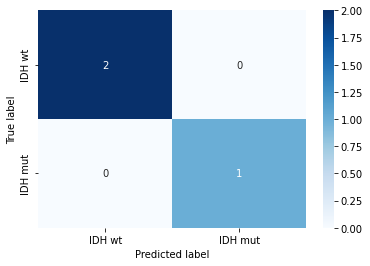

In [ ]:
# We can also print a confusion matrix

target_names = ['IDH wt', 'IDH mut']

sub_predictions = svm_clf.predict(X_test_std)
conf_matrix_sub = confusion_matrix(y_test,sub_predictions)
sns.heatmap(conf_matrix_sub, annot=True,fmt='d',
            xticklabels=target_names,
            yticklabels=target_names,
            cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_test, sub_predictions,target_names=target_names))

              precision    recall  f1-score   support

      IDH wt       1.00      1.00      1.00         2
     IDH mut       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [ ]:
# Obtains the inputs to use to build a precision-recall and an ROC curve

y_score_sub = svm_clf.decision_function(X_test_std)

Average precision-recall score: 1.00


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

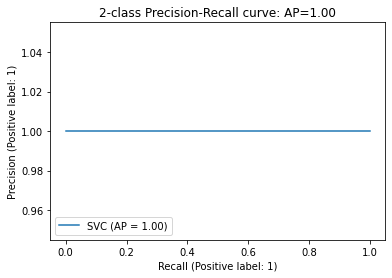

In [ ]:
# Plots a precision-recall curve

average_precision_eval = average_precision_score(y_test, y_score_sub)

print('Average precision-recall score: {0:0.2f}'.format(average_precision_eval))

disp = plot_precision_recall_curve(svm_clf, X_test_std, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_eval))

AUC: 1.000


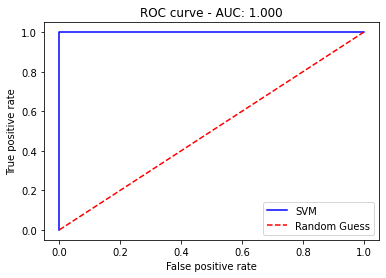

In [ ]:
# Plots an ROC curve

sub_decision_scores = svm_clf.decision_function(X_test_std)
fpr, tpr, thres = roc_curve(y_test, sub_decision_scores)
print('AUC: {:.3f}'.format(roc_auc_score(y_test, sub_decision_scores)))

# roc curve
plt.plot(fpr, tpr, "b", label='SVM')
plt.plot([0,1],[0,1], "r--", label='Random Guess')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="best")
plt.title("ROC curve - "+'AUC: {:.3f}'.format(roc_auc_score(y_test, sub_decision_scores)))
plt.show()

# DO TRY THIS AT HOME

- Obtain the segmentation masks of the whole TCGA-GBM cohort.
- Binarize the segmentation masks to extract radiomics features from the whole lesion.
- Extract radiomics features from MRI sequences other than T2 (i.e., FLAIR, post-contrast T1)
- Modify the YML file to extract the radiomics features from another sub-region of the tumors.
- Perform a gridsearch for the model.
- Train a model different than a SVM.